## Import library

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Read the Data

In [ ]:
df = pd.read_csv('application_train.csv')


In [ ]:
df.sample(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
255229,395325,0,Cash loans,F,N,N,2,225000.0,450000.0,27193.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
df.dtypes

,0
SK_ID_CURR,int64
TARGET,int64
NAME_CONTRACT_TYPE,object
CODE_GENDER,object
FLAG_OWN_CAR,object
...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64
AMT_REQ_CREDIT_BUREAU_WEEK,float64
AMT_REQ_CREDIT_BUREAU_MON,float64
AMT_REQ_CREDIT_BUREAU_QRT,float64


## The number of customers who apply for loans

In [ ]:
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

noc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,Customers_pct
0,0,282686,0.92
1,1,24825,0.08


# Data Cleaning

## Detecting and remove data duplicate

In [ ]:
df.duplicated().sum()

0

In [ ]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
48,COMMONAREA_AVG,214865,69.872297
76,COMMONAREA_MEDI,214865,69.872297
62,COMMONAREA_MODE,214865,69.872297
84,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
70,NONLIVINGAPARTMENTS_MODE,213514,69.432963
56,NONLIVINGAPARTMENTS_AVG,213514,69.432963
86,FONDKAPREMONT_MODE,210295,68.386172
82,LIVINGAPARTMENTS_MEDI,210199,68.354953
54,LIVINGAPARTMENTS_AVG,210199,68.354953
68,LIVINGAPARTMENTS_MODE,210199,68.354953


In [ ]:
data = list(count_nv[count_nv['Percentage'] > 40]['index'])
df = df.drop(columns = data)
df = df.drop(columns = 'SK_ID_CURR')

In [ ]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
still_null = count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [ ]:
a = list(still_null['index'])
df[a].dtypes

for i in a:
    data = df[i]
    types = str(data.dtype)
    if types == 'object':
        df[i].fillna(df[i].mode()[0], inplace=True)
    else:
        df[i].fillna(df[i].median(), inplace=True)

In [ ]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


## Replace Unknown Value

In [ ]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

## Remove flag document column

In [ ]:
FLAG_DOCUMENT = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df.drop(columns = FLAG_DOCUMENT, axis=1, inplace=True)

# Data Classification

In [ ]:
x = df.drop(columns = 'TARGET')

In [ ]:
num = x.select_dtypes(exclude='object')

In [ ]:
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


### Change the negative value on column to positive value

In [ ]:
# Identify columns with negative values and make them positive
negative_column = num.columns[(num < 0).any()].tolist()
num[negative_column] = num[negative_column].abs()  # Using .abs() for clarity and consistency

In [ ]:
df_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
df_num = df_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 3:
        num_a.append(y)
    else:
        num_b.append(y)

### Look at the distribution of data

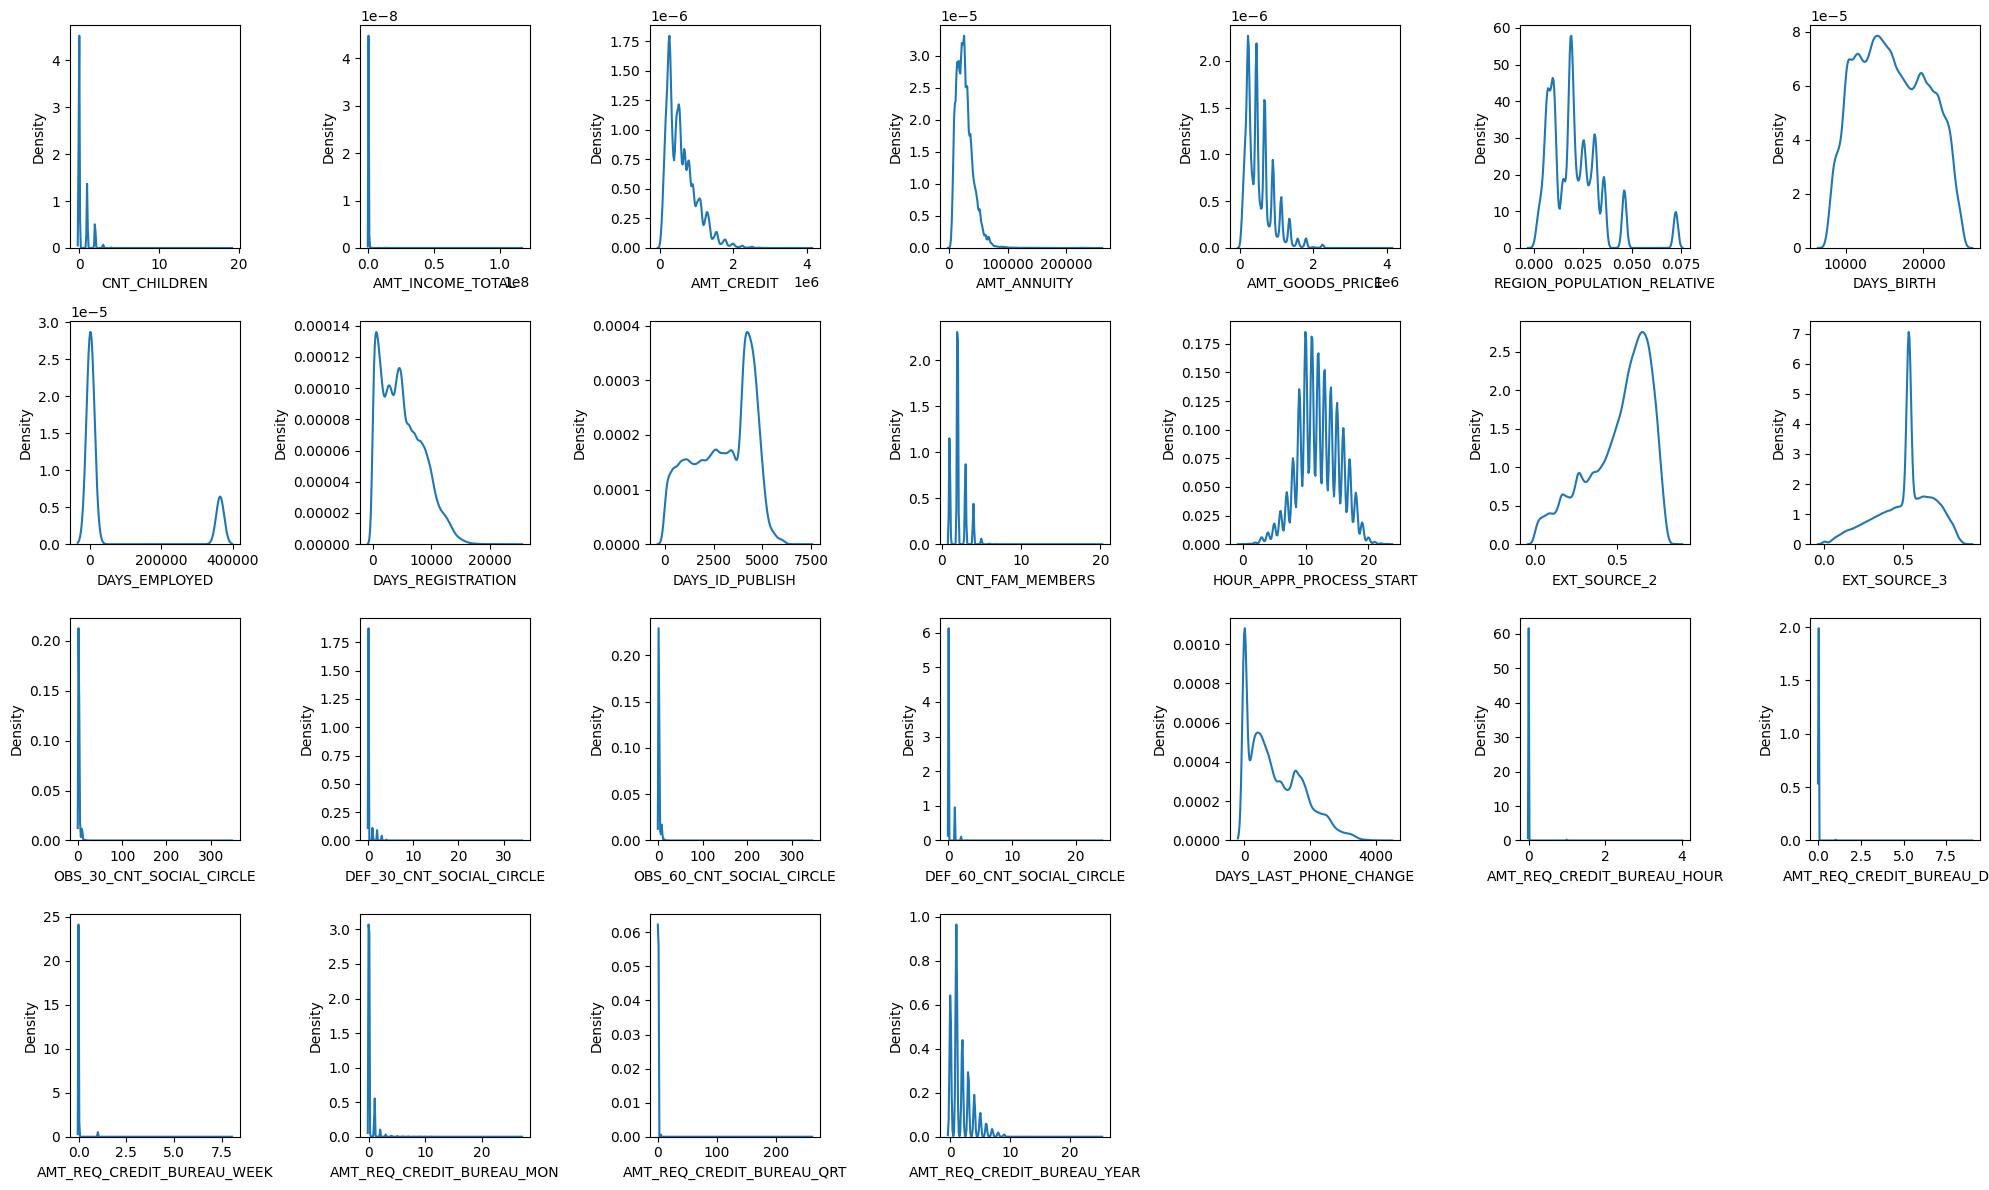

In [ ]:
# Begin plotting
plt.figure(figsize=(20, 12))

# Iterate through the columns in num_a and plot them
for i, column in enumerate(num_a, 1):  # Ensure correct enumeration with num_a
    plt.subplot(4, 7, i)

    # Plot KDE for each column, ensuring DAYS_EMPLOYED has only positive values
    sns.kdeplot(data=num, x=column)  # Explicitly specify data and x for each plot

    plt.tight_layout()

the data distribution is not close to the normal distribution, so it needs to be normalized

### Kesimpulan

1. **Bentuk Distribusi**: Sebagian besar kolom numerik menunjukkan distribusi yang tidak simetris atau skewed, dengan beberapa kolom menunjukkan distribusi normal.
2. **Outliers**: Beberapa kolom menunjukkan lonjakan tajam di ujung distribusi, yang menandakan adanya outliers yang signifikan.
3. **Skewness**: Distribusi data yang skewed menandakan bahwa data tidak terdistribusi merata. Transformasi data mungkin diperlukan untuk mengurangi skewness.
4. **Variabilitas**: Sebaran data cukup lebar pada beberapa kolom, menunjukkan variabilitas yang tinggi.

Kesimpulan keseluruhan: Data distribusi tidak mendekati distribusi normal, sehingga perlu dilakukan **normalisasi** atau transformasi untuk membuat distribusi lebih merata dan mendekati distribusi normal.


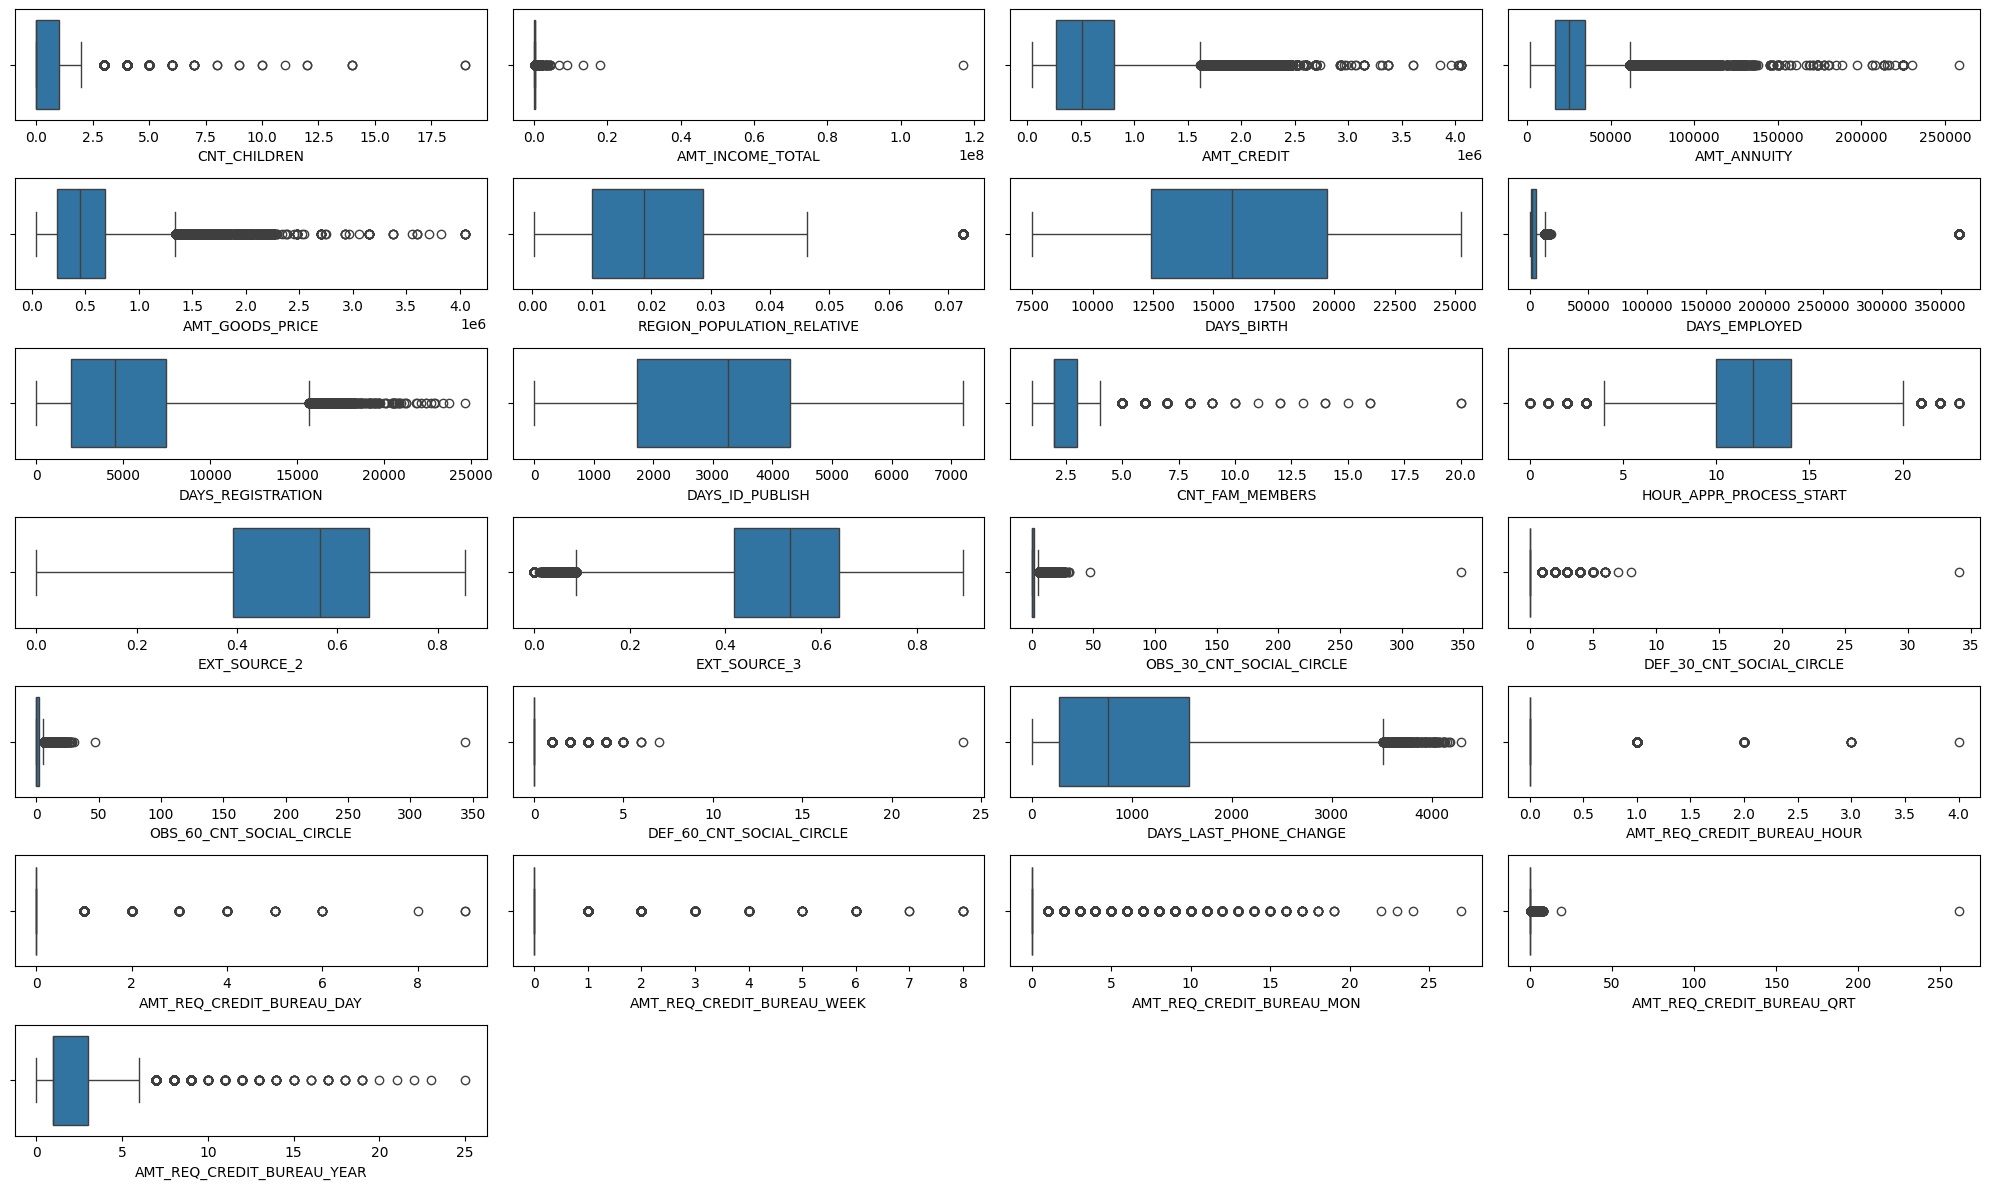

In [ ]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(7,4,i)
    sns.boxplot(data=num[num_a], x=num[column])
    plt.tight_layout()

Kolom yang memiliki nilai abnormal adalah **CNT_CHILDREN** dan **DAYS_EMPLOYED**, sehingga kita perlu menghapus outlier pada kedua kolom ini.

- Untuk **CNT_CHILDREN**, nilai yang sangat tinggi (misalnya, lebih dari 10 anak) jarang terjadi dan dapat mengganggu analisis, sehingga sebaiknya dihapus.

- Untuk **DAYS_EMPLOYED**, nilai yang sangat besar (misalnya, ribuan hari bekerja) kemungkinan merupakan kesalahan atau tidak realistis, sehingga outlier pada kolom ini juga perlu dihapus untuk menjaga integritas data.


# Handle Outliers

**Remove Outlier**

In [ ]:
print(f'Row before deleting outliers at CNT_CHILDREN and DAYS_EMPLOYED: {len(df)}')

# Filter outliers for both CNT_CHILDREN and DAYS_EMPLOYED
filtered_entries = np.array([True] * len(df))

# Calculate z-scores for both columns
zscore_children = abs(stats.zscore(df['CNT_CHILDREN']))
zscore_employed = abs(stats.zscore(df['DAYS_EMPLOYED']))

# Keep only rows where z-score is less than 3 for both columns
filtered_entries = (zscore_children < 3) & (zscore_employed < 3)

# Apply filter to the dataframe
df = df[filtered_entries]

print(f'Row after deleting outliers at CNT_CHILDREN and DAYS_EMPLOYED: {len(df)}')


Row before deleting outliers at CNT_CHILDREN and DAYS_EMPLOYED: 307511
Row after deleting outliers at CNT_CHILDREN and DAYS_EMPLOYED: 303239


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Identify categorical columns or columns with a small number of unique values
kolom_kategorikal = df.select_dtypes(include=['object']).columns.tolist()

# Add columns with fewer than 10 unique values (but not of object type)
kolom_kategorikal += [
    col for col in df.columns
    if df[col].nunique() < 10 and df[col].dtype != 'object'
]

# Store Chi-Square test results
chi_square_results = []

# Perform Chi-Square test on each categorical column
for kolom in kolom_kategorikal:
    try:
        # Create contingency table
        tabel_kontingensi = pd.crosstab(df[kolom], df['TARGET'])

        # Perform Chi-Square test
        chi2, p, dof, expected = chi2_contingency(tabel_kontingensi)

        # Append the results to the list
        chi_square_results.append({'Feature': kolom, 'Chi2': chi2, 'P-value': p})

        # Print the results
        print(f"Uji Chi-Square untuk {kolom}")
        print(f"Chi2 Statistik: {chi2}, p-value: {p}\n")

    except ValueError:
        print(f"Kolom {kolom} tidak bisa dihitung dengan Chi-Square karena terlalu sedikit nilai unik.\n")

# Convert results to a DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Calculate Chi2 % contribution (percentage of total Chi2)
total_chi2_sum = chi_square_results_df['Chi2'].sum()
chi_square_results_df['Chi2 %'] = (chi_square_results_df['Chi2'] / total_chi2_sum) * 100

# Sort by P-value for easier inspection
chi_square_results_sorted = chi_square_results_df.sort_values(by='P-value')

# Filter insignificant features (P-value >= 0.05 and Chi2 % < 1)
insignificant_features = chi_square_results_sorted[
    (chi_square_results_sorted['P-value'] >= 0.05) &
    (chi_square_results_sorted['Chi2 %'] < 1)
]

# Display the features to drop
print("Features to drop:")
print(insignificant_features[['Feature', 'Chi2', 'P-value', 'Chi2 %']])

Uji Chi-Square untuk NAME_CONTRACT_TYPE
Chi2 Statistik: 287.2119880600969, p-value: 2.0139507291464577e-64

Uji Chi-Square untuk CODE_GENDER
Chi2 Statistik: 939.7915932223743, p-value: 2.1969079015125986e-206

Uji Chi-Square untuk FLAG_OWN_CAR
Chi2 Statistik: 143.9465687341119, p-value: 3.649831302018177e-33

Uji Chi-Square untuk FLAG_OWN_REALTY
Chi2 Statistik: 12.509654723947362, p-value: 0.00040485441677351377

Uji Chi-Square untuk NAME_TYPE_SUITE
Chi2 Statistik: 29.610493729279156, p-value: 4.6609088797921965e-05

Uji Chi-Square untuk NAME_INCOME_TYPE
Chi2 Statistik: 1232.5647017264591, p-value: 6.406359491917325e-262

Uji Chi-Square untuk NAME_EDUCATION_TYPE
Chi2 Statistik: 981.5616599239881, p-value: 3.5348038485971814e-211

Uji Chi-Square untuk NAME_FAMILY_STATUS
Chi2 Statistik: 503.374914902838, p-value: 1.4919969676022953e-106

Uji Chi-Square untuk NAME_HOUSING_TYPE
Chi2 Statistik: 421.84283848598784, p-value: 5.802580966873002e-89

Uji Chi-Square untuk OCCUPATION_TYPE
Chi2 Sta

In [ ]:
import pandas as pd

# Seleksi kolom bertipe float64 dan int64
num = df.select_dtypes(include=['float64', 'int64'])

# Buat DataFrame dengan jumlah nilai unik
df_num = pd.DataFrame(num.nunique(), columns=['Total_unique']).reset_index()

# Ganti nama kolom menjadi lebih deskriptif
df_num = df_num.rename(columns={'index': 'Name_of_column'})

# Tambahkan kolom dengan nilai standar deviasi, maksimum, dan minimum
df_num['Std_value'] = num.std().reset_index(drop=True)
df_num['Max'] = num.max().values
df_num['Min'] = num.min().values

# Urutkan berdasarkan standar deviasi tertinggi dan tampilkan 20 teratas
df_num_sorted = df_num.sort_values('Std_value', ascending=False).head(20)

# Tampilkan hasil
df_num_sorted

,Name_of_column,Total_unique,Std_value,Max,Min
3,AMT_CREDIT,5589,402543.412370,4050000.0,45000.0
5,AMT_GOODS_PRICE,996,369361.303495,4050000.0,40500.0
2,AMT_INCOME_TOTAL,2530,238412.564867,117000000.0,25650.0
8,DAYS_EMPLOYED,12568,141939.210036,365243.0,-17912.0
4,AMT_ANNUITY,13648,14479.444227,258025.5,1615.5
7,DAYS_BIRTH,17460,4378.343498,-7489.0,-25229.0
9,DAYS_REGISTRATION,15688,3528.300784,0.0,-24672.0
10,DAYS_ID_PUBLISH,6165,1509.095307,0.0,-7197.0
33,DAYS_LAST_PHONE_CHANGE,3772,827.243794,0.0,-4292.0
20,HOUR_APPR_PROCESS_START,24,3.266333,23.0,0.0


# Feature Selection

In [ ]:
# Select only numerical columns (float64 and int64)
num = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = num.corr()

# Identify pairs of highly correlated features (correlation > 0.9)
threshold = 0.9
features_to_drop = set()  # Use a set to avoid duplicates

# Iterate through the upper triangle of the matrix to find correlations > 0.9
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Add the second feature to the set (keep one of the pair)
            features_to_drop.add(correlation_matrix.columns[j])

# Display the correlation matrix
print("Correlation Matrix for Numerical Columns:")
print(correlation_matrix)

# Display the features to drop
print("\nFeatures to drop due to high correlation:")
print(features_to_drop)

Correlation Matrix for Numerical Columns:
                               TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
TARGET                       1.000000      0.016989         -0.003774   
CNT_CHILDREN                 0.016989      1.000000          0.013572   
AMT_INCOME_TOTAL            -0.003774      0.013572          1.000000   
AMT_CREDIT                  -0.030422      0.001490          0.155767   
AMT_ANNUITY                 -0.012856      0.020458          0.190028   
AMT_GOODS_PRICE             -0.039632     -0.002519          0.158455   
REGION_POPULATION_RELATIVE  -0.037283     -0.023277          0.074190   
DAYS_BIRTH                   0.078160      0.343917          0.027682   
DAYS_EMPLOYED               -0.044938     -0.248031         -0.064274   
DAYS_REGISTRATION            0.041885      0.180624          0.027828   
DAYS_ID_PUBLISH              0.051632     -0.023684          0.008655   
FLAG_MOBIL                   0.000537      0.001070          0.000325   
FLAG_EMP_

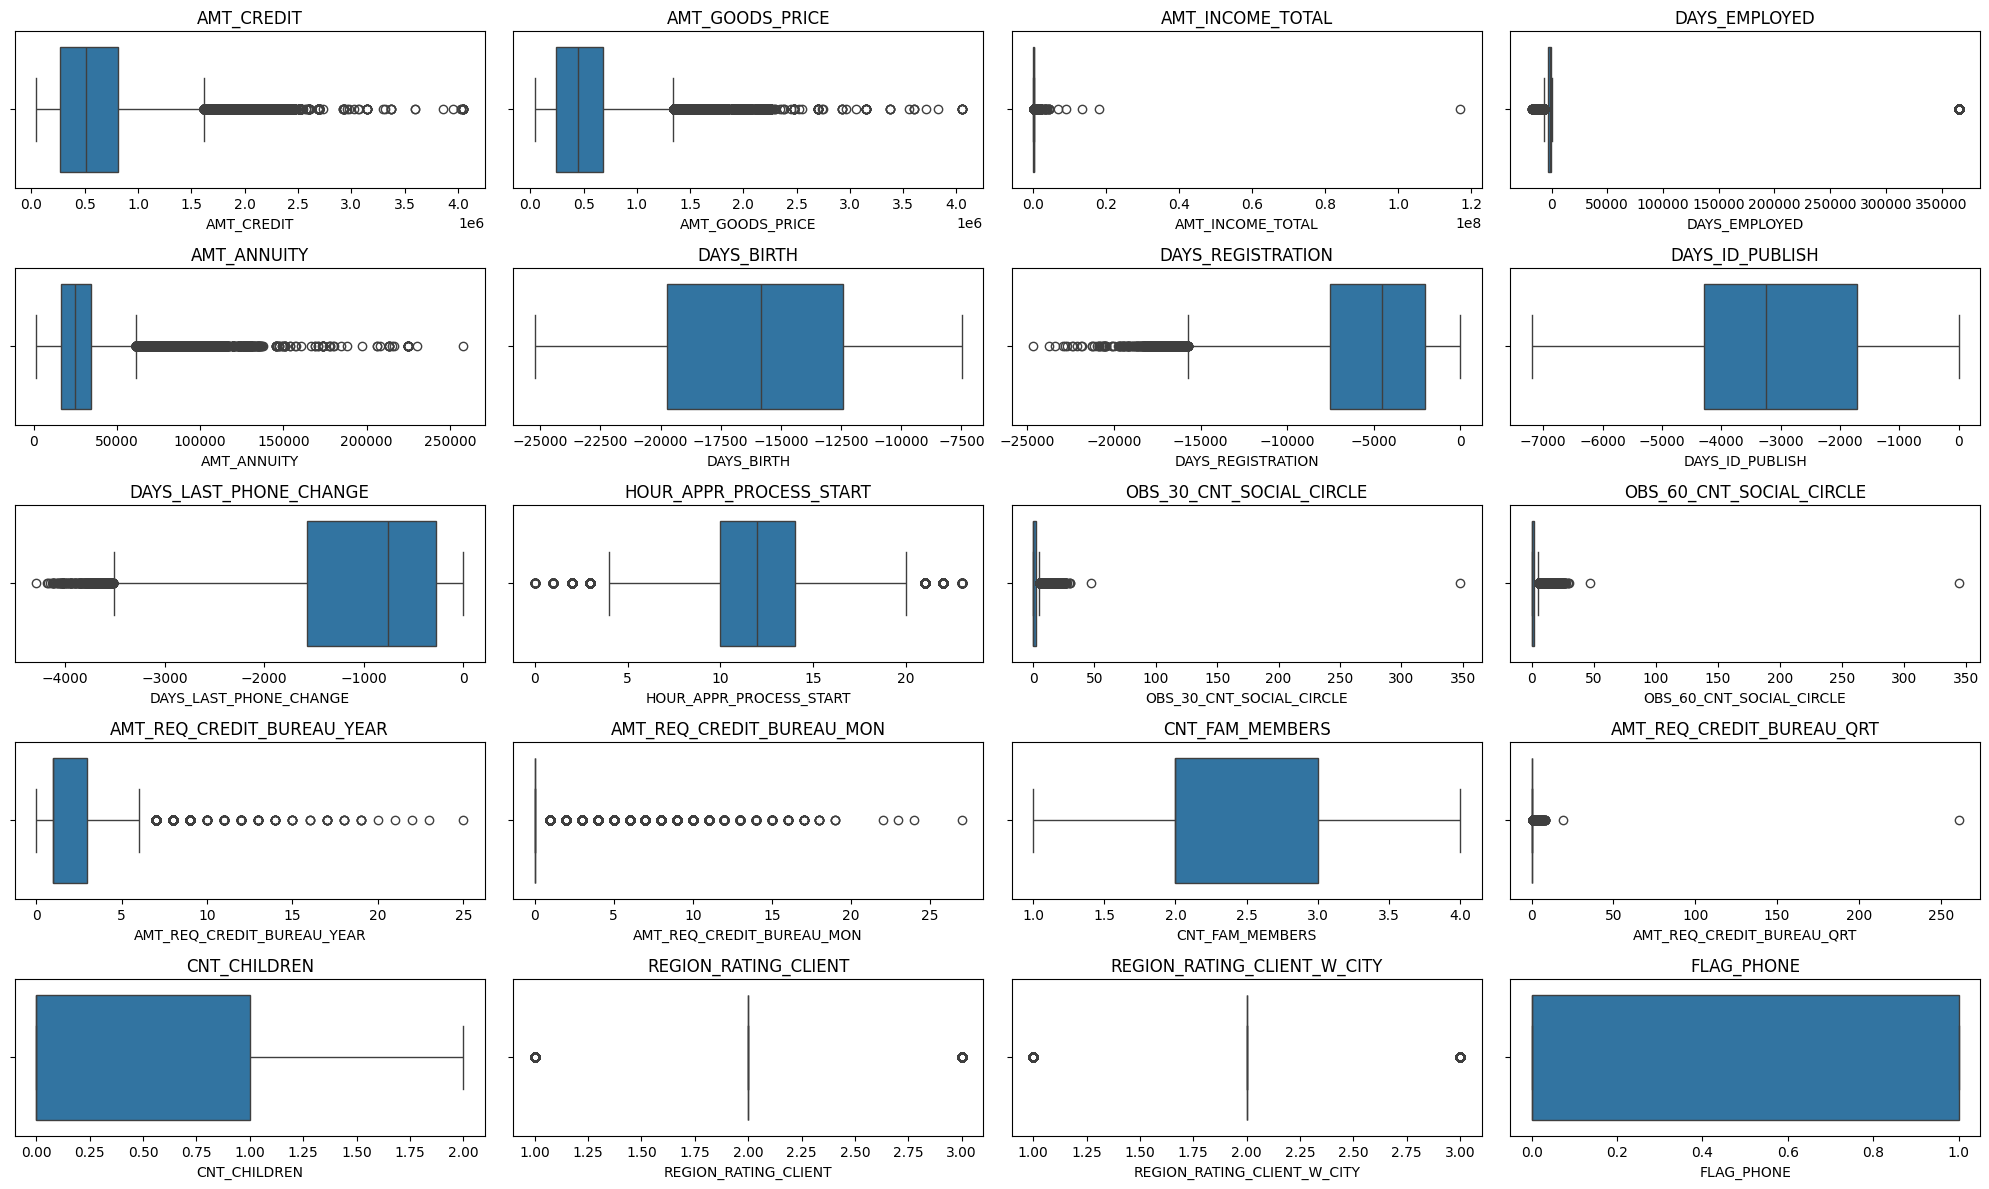

In [ ]:
# Seleksi kolom bertipe float64 dan int64
num = df.select_dtypes(include=['float64', 'int64'])

# Buat DataFrame dengan jumlah nilai unik
df_num = pd.DataFrame(num.nunique(), columns=['Total_unique']).reset_index()

# Ganti nama kolom menjadi lebih deskriptif
df_num = df_num.rename(columns={'index': 'Name_of_column'})

# Tambahkan kolom dengan nilai standar deviasi, maksimum, dan minimum
df_num['Std_value'] = num.std().reset_index(drop=True)
df_num['Max'] = num.max().values
df_num['Min'] = num.min().values

# Sort the DataFrame by the 'Std_value' column in descending order and get the top 20
top_20_features = df_num.sort_values('Std_value', ascending=False).head(20)['Name_of_column'].tolist()

# Create boxplots for the top 20 features
plt.figure(figsize=(20, 12))
for i, column in enumerate(top_20_features, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(data=num, x=column)
    plt.title(column)
    plt.tight_layout()

# Tampilkan plot
plt.show()


# Drop Feature

In [ ]:
df = df.drop(columns=['LIVE_REGION_NOT_WORK_REGION','FLAG_EMAIL','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_WEEK','FLAG_CONT_MOBILE',
         'FLAG_MOBIL','FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY',
         'OBS_60_CNT_SOCIAL_CIRCLE','AMT_GOODS_PRICE'])

## Feature Encoding

In [ ]:
df_train =df.copy()

In [ ]:
df_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Unaccompanied,...,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,-1134.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,Family,...,School,0.622246,0.535276,1.0,0.0,0.0,-828.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Unaccompanied,...,Government,0.555912,0.729567,0.0,0.0,0.0,-815.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Unaccompanied,...,Business Entity Type 3,0.650442,0.535276,2.0,0.0,0.0,-617.0,0.0,0.0,1.0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Unaccompanied,...,Religion,0.322738,0.535276,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0


In [ ]:
# List of features to convert to 'object' type
features_to_convert = [
    'TARGET', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY', 'CNT_FAM_MEMBERS'
]

# Convert the data types of the specified features to 'object'
for feature in features_to_convert:
    if feature in df_train.columns:
        df_train[feature] = df_train[feature].astype('object')

# Confirm the data types have been changed
print(df_train[features_to_convert].dtypes)

TARGET                        object
FLAG_WORK_PHONE               object
FLAG_PHONE                    object
REG_REGION_NOT_LIVE_REGION    object
REG_REGION_NOT_WORK_REGION    object
REG_CITY_NOT_LIVE_CITY        object
REG_CITY_NOT_WORK_CITY        object
LIVE_CITY_NOT_WORK_CITY       object
CNT_FAM_MEMBERS               object
dtype: object


In [ ]:
# Check the data types of all columns in df_train
column_types = df_train.dtypes

# Separate numerical and categorical columns
nums = column_types[column_types != 'object'].index.tolist()  # Numerical columns
cats = column_types[column_types == 'object'].index.tolist()  # Categorical columns

# Print the results
print("Numerical Columns:")
print(nums)

print("\nCategorical Columns:")
print(cats)


Numerical Columns:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

Categorical Columns:
['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE']


In [ ]:
# 1. Binary Encoding for Yes/No Columns
yes_no_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
for col in yes_no_cols:
    df_train[col] = df_train[col].map({'Y': 1, 'N': 0})

# 2. Mapping for CODE_GENDER
df_train['CODE_GENDER'] = df_train['CODE_GENDER'].map({'M': 1, 'F': 0})

# 3. Mapping for NAME_CONTRACT_TYPE
df_train['NAME_CONTRACT_TYPE'] = df_train['NAME_CONTRACT_TYPE'].map({'Cash loans': 1, 'Revolving loans': 0})

# Verify the mapping result
print(df_train[['CODE_GENDER']].head())
print(df_train[yes_no_cols].head())
print(df_train[['NAME_CONTRACT_TYPE']].head())

# 4. One-Hot Encoding with 1/0 Values
one_hot_cols = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

# Perform one-hot encoding
df_train = pd.get_dummies(df_train, columns=one_hot_cols, drop_first=True)

# 5. Handle NaNs and Infer Correct Data Types
df_train = df_train.fillna(0)  # Replace NaNs with 0
df_train = df_train.infer_objects(copy=False)  # Infer object types to int or float

# 6. Ensure all columns are integers
df_train_encoded = df_train.astype(int)

# Verify the transformed data
print(df_train_encoded.info())  # Check data types and number of columns
print(df_train_encoded.head())  # Display the first few rows to verify

   CODE_GENDER
0            1
1            0
2            1
3            0
4            1
   FLAG_OWN_CAR  FLAG_OWN_REALTY
0             0                1
1             0                0
2             1                1
3             0                1
4             0                1
   NAME_CONTRACT_TYPE
0                   1
1                   1
2                   0
3                   1
4                   1
<class 'pandas.core.frame.DataFrame'>
Index: 303239 entries, 0 to 307510
Columns: 141 entries, TARGET to ORGANIZATION_TYPE_University
dtypes: int64(141)
memory usage: 328.5 MB
None
   TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                   1            1             0                1   
1       0                   1            0             0                0   
2       0                   0            1             1                1   
3       0                   1            0             0                1   
4       0     

<ipython-input-36-1b656693007e>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train = df_train.fillna(0)  # Replace NaNs with 0


# Feature Engineering 1

# New Feature

In [ ]:
# Menghitung persentase masa kerja seseorang terhadap usia, sehingga dapat memberi informasi terkait dengan awal memulai karir
df_train_encoded['NEW_DAYS_EMPLOYED_PERC'] = df_train_encoded['DAYS_EMPLOYED'] / df_train_encoded['DAYS_BIRTH']

# Menghitung persentase pendapatan total terhadap jumlah kredit, sehingga dapat mengetahui kemampuan nasabah dalam membayar
df_train_encoded['NEW_INCOME_CREDIT_PERC'] = df_train_encoded['AMT_INCOME_TOTAL'] / df_train_encoded['AMT_CREDIT']

# Menghitung persentase angsuran kredit terhadap pendapatan total, untuk mengetahui beban kredit nasabah
df_train_encoded['NEW_ANNUITY_INCOME_PERC'] = df_train_encoded['AMT_ANNUITY'] / df_train_encoded['AMT_INCOME_TOTAL']

# Untuk mengetahui tingkat pembayaran kredit, seberapa cepat kredit dapat lunas
df_train_encoded['NEW_PAYMENT_RATE'] = df_train_encoded['AMT_ANNUITY'] / df_train_encoded['AMT_CREDIT']

In [ ]:
df_train_encoded.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_ANNUITY_INCOME_PERC,NEW_PAYMENT_RATE
0,1,1,1,0,1,0,202500,406597,24700,0,...,0,0,0,0,0,0,0.067329,0.498036,0.121975,0.060748
1,0,1,0,0,0,0,270000,1293502,35698,0,...,0,0,0,0,0,0,0.070862,0.208736,0.132215,0.027598
2,0,0,1,1,1,0,67500,135000,6750,0,...,0,0,0,0,0,0,0.011814,0.500000,0.100000,0.050000
3,0,1,0,0,1,0,135000,312682,29686,0,...,0,0,0,0,0,0,0.159905,0.431749,0.219896,0.094940
4,0,1,1,0,1,0,121500,513000,21865,0,...,0,0,0,0,0,0,0.152418,0.236842,0.179959,0.042622


In [ ]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303239 entries, 0 to 307510
Columns: 145 entries, TARGET to NEW_PAYMENT_RATE
dtypes: float64(4), int64(141)
memory usage: 337.8 MB


# Feature Transformation

## Log Transformation

In [ ]:
import numpy as np

# Copy dataset to preserve original data
df_train_log = df_train_encoded.copy()

# List of columns to apply log transformation
cols_to_log_transform = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

# Apply log transformation (with a small constant to avoid log(0))
for col in cols_to_log_transform:
    df_train_log[col] = np.log1p(df_train_log[col])

# Display the transformed dataset
print(df_train_log[cols_to_log_transform].head())


   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY
0         12.218500   12.915580    10.114599
1         12.506181   14.072865    10.482878
2         11.119898   11.813037     8.817446
3         11.813037   12.652945    10.298465
4         11.707678   13.148033     9.992688


## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# List of columns to normalize
cols_to_normalize = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler on the log-transformed columns
df_train_log[cols_to_normalize] = scaler.fit_transform(df_train_log[cols_to_normalize])

# Display the normalized dataset
print(df_train_log[cols_to_normalize].head())


   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY
0          0.245232    0.489165     0.537519
1          0.279376    0.746352     0.610113
2          0.114839    0.244144     0.281827
3          0.197108    0.430799     0.573762
4          0.184602    0.540824     0.513488


In [ ]:
df_train_log.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_ANNUITY_INCOME_PERC,NEW_PAYMENT_RATE
0,1,1,1,0,1,0,0.245232,0.489165,0.537519,0,...,0,0,0,0,0,0,0.067329,0.498036,0.121975,0.060748
1,0,1,0,0,0,0,0.279376,0.746352,0.610113,0,...,0,0,0,0,0,0,0.070862,0.208736,0.132215,0.027598
2,0,0,1,1,1,0,0.114839,0.244144,0.281827,0,...,0,0,0,0,0,0,0.011814,0.500000,0.100000,0.050000
3,0,1,0,0,1,0,0.197108,0.430799,0.573762,0,...,0,0,0,0,0,0,0.159905,0.431749,0.219896,0.094940
4,0,1,1,0,1,0,0.184602,0.540824,0.513488,0,...,0,0,0,0,0,0,0.152418,0.236842,0.179959,0.042622


In [ ]:
# Save DataFrame as CSV file
df_train_log.to_csv("df_train_log.csv", index=False)

# Split Data

In [ ]:
x = df_train_log.drop(columns = 'TARGET')
y = df_train_log['TARGET']

# Feature Engineering 2

# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Memisahkan fitur (X) dan target (y)
X = df_train_log.drop(columns='TARGET')
y = df_train_log['TARGET']

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Terapkan StandardScaler ke fitur
X_scaled = scaler.fit_transform(X)

# Menampilkan beberapa baris pertama dari X_scaled
print(pd.DataFrame(X_scaled, columns=X.columns).head())


   NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0            0.324189     1.390300     -0.715531         0.665112   
1            0.324189    -0.719269     -0.715531        -1.503506   
2           -3.084622     1.390300      1.397564         0.665112   
3            0.324189    -0.719269     -0.715531         0.665112   
4            0.324189     1.390300     -0.715531         0.665112   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.589199          0.633425   -0.215579     0.086951   
1     -0.589199          1.222404    1.402158     0.761529   
2     -0.589199         -1.615780   -1.756794    -2.289051   
3     -0.589199         -0.196692   -0.582710     0.423738   
4     -0.589199         -0.412398    0.109361    -0.136354   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                         0.0    1.509513  ...   
1                         0.0   -0.158701  ...   
2                         0.0   -0.679675  ...   
3           

# Handle Class Imbalance

## Oversampling (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Inisialisasi SMOTE
smote = SMOTE(sampling_strategy=0.5)  # Menambah kelas minoritas hingga mencapai 50% dari kelas mayoritas

# Terapkan SMOTE ke data yang sudah discaling
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# Print distribusi kelas setelah SMOTE
print(f'Distribusi kelas sebelum SMOTE: {Counter(y)}')
print(f'Distribusi kelas setelah SMOTE: {Counter(y_smote)}')

# Optional: Tampilkan beberapa baris data hasil resampling
print(pd.DataFrame(X_smote, columns=X.columns).head())


Distribusi kelas sebelum SMOTE: Counter({0: 278843, 1: 24396})
Distribusi kelas setelah SMOTE: Counter({0: 278843, 1: 139421})
   NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0            0.324189     1.390300     -0.715531         0.665112   
1            0.324189    -0.719269     -0.715531        -1.503506   
2           -3.084622     1.390300      1.397564         0.665112   
3            0.324189    -0.719269     -0.715531         0.665112   
4            0.324189     1.390300     -0.715531         0.665112   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.589199          0.633425   -0.215579     0.086951   
1     -0.589199          1.222404    1.402158     0.761529   
2     -0.589199         -1.615780   -1.756794    -2.289051   
3     -0.589199         -0.196692   -0.582710     0.423738   
4     -0.589199         -0.412398    0.109361    -0.136354   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                         0.0    1.

## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Inisialisasi RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.8)  # Mengurangi jumlah kelas mayoritas hingga mencapai 80% dari jumlah kelas minoritas

# Terapkan RandomUnderSampler ke data yang sudah discaling
X_under, y_under = undersample.fit_resample(X_scaled, y)

# Print distribusi kelas setelah undersampling
print(f'Distribusi kelas sebelum undersampling: {Counter(y)}')
print(f'Distribusi kelas setelah undersampling: {Counter(y_under)}')

# Optional: Tampilkan beberapa baris data hasil resampling
print(pd.DataFrame(X_under, columns=X.columns).head())


Distribusi kelas sebelum undersampling: Counter({0: 278843, 1: 24396})
Distribusi kelas setelah undersampling: Counter({0: 30495, 1: 24396})
   NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           -3.084622    -0.719269      1.397564         0.665112   
1            0.324189    -0.719269     -0.715531         0.665112   
2            0.324189     1.390300     -0.715531         0.665112   
3           -3.084622     1.390300      1.397564        -1.503506   
4            0.324189    -0.719269     -0.715531         0.665112   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.589199          0.118904   -0.073800    -0.083918   
1     -0.589199          0.889675    1.313586     1.128170   
2     -0.589199         -0.569962    0.253838     0.502301   
3     -0.589199          0.287272   -1.541313    -2.006731   
4     -0.589199         -1.026807   -0.869413     0.048887   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                    

# Test Model

## Model Initialization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Original data split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Oversampled data split (e.g., using SMOTE)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Undersampled data split
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.3, random_state=42)


## 1. Logistic Regression

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
# Suppress convergence warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model')

print("=== Logistic Regression ===")

# Original Data
print("\nOriginal Data:")
logistic_model = LogisticRegression()
logistic_model.fit(X_train_orig, y_train_orig)
y_pred_orig = logistic_model.predict(X_test_orig)
y_pred_proba_orig = logistic_model.predict_proba(X_test_orig)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_orig, y_pred_orig))
print("Accuracy Score (Original):", accuracy_score(y_test_orig, y_pred_orig))
print("ROC AUC Score (Original):", roc_auc_score(y_test_orig, y_pred_proba_orig))

# Oversampled Data
print("\nOversampled Data:")
logistic_model.fit(X_train_over, y_train_over)
y_pred_over = logistic_model.predict(X_test_over)
y_pred_proba_over = logistic_model.predict_proba(X_test_over)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_over, y_pred_over))
print("Accuracy Score (Oversampled):", accuracy_score(y_test_over, y_pred_over))
print("ROC AUC Score (Oversampled):", roc_auc_score(y_test_over, y_pred_proba_over))

# Undersampled Data
print("\nUndersampled Data:")
logistic_model.fit(X_train_under, y_train_under)
y_pred_under = logistic_model.predict(X_test_under)
y_pred_proba_under = logistic_model.predict_proba(X_test_under)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_under, y_pred_under))
print("Accuracy Score (Undersampled):", accuracy_score(y_test_under, y_pred_under))
print("ROC AUC Score (Undersampled):", roc_auc_score(y_test_under, y_pred_proba_under))


=== Logistic Regression ===

Original Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83695
           1       0.50      0.00      0.00      7277

    accuracy                           0.92     90972
   macro avg       0.71      0.50      0.48     90972
weighted avg       0.89      0.92      0.88     90972

Accuracy Score (Original): 0.9200083542188805
ROC AUC Score (Original): 0.6799191555372235

Oversampled Data:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80     83604
           1       0.58      0.29      0.39     41876

    accuracy                           0.69    125480
   macro avg       0.65      0.59      0.59    125480
weighted avg       0.67      0.69      0.66    125480

Accuracy Score (Oversampled): 0.6930745935607268
ROC AUC Score (Oversampled): 0.7044236401931738

Undersampled Data:
              precision    recall  f1-score   support

           0       0

## 2. Random Forest

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings
# Suppress convergence warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model')

print("\n=== Random Forest ===")

# Original Data
print("\nOriginal Data:")
rf_model = RandomForestClassifier()
rf_model.fit(X_train_orig, y_train_orig)
y_pred_rf_orig = rf_model.predict(X_test_orig)
y_pred_proba_rf_orig = rf_model.predict_proba(X_test_orig)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_orig, y_pred_rf_orig))
print("Accuracy Score (Original):", accuracy_score(y_test_orig, y_pred_rf_orig))
print("ROC AUC Score (Original):", roc_auc_score(y_test_orig, y_pred_proba_rf_orig))

# Oversampled Data
print("\nOversampled Data:")
rf_model.fit(X_train_over, y_train_over)
y_pred_rf_over = rf_model.predict(X_test_over)
y_pred_proba_rf_over = rf_model.predict_proba(X_test_over)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_over, y_pred_rf_over))
print("Accuracy Score (Oversampled):", accuracy_score(y_test_over, y_pred_rf_over))
print("ROC AUC Score (Oversampled):", roc_auc_score(y_test_over, y_pred_proba_rf_over))

# Undersampled Data
print("\nUndersampled Data:")
rf_model.fit(X_train_under, y_train_under)
y_pred_rf_under = rf_model.predict(X_test_under)
y_pred_proba_rf_under = rf_model.predict_proba(X_test_under)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_under, y_pred_rf_under))
print("Accuracy Score (Undersampled):", accuracy_score(y_test_under, y_pred_rf_under))
print("ROC AUC Score (Undersampled):", roc_auc_score(y_test_under, y_pred_proba_rf_under))



=== Random Forest ===

Original Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83695
           1       1.00      0.00      0.00      7277

    accuracy                           0.92     90972
   macro avg       0.96      0.50      0.48     90972
weighted avg       0.93      0.92      0.88     90972

Accuracy Score (Original): 0.9200193466121444
ROC AUC Score (Original): 0.6555796749623467

Oversampled Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96     83604
           1       1.00      0.81      0.90     41876

    accuracy                           0.94    125480
   macro avg       0.96      0.91      0.93    125480
weighted avg       0.94      0.94      0.94    125480

Accuracy Score (Oversampled): 0.9373445967484858
ROC AUC Score (Oversampled): 0.965221414137549

Undersampled Data:
              precision    recall  f1-score   support

           0       0.64   

## 3. XGBoost

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import xgboost as xgb
import warnings
# Suppress convergence warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.linear_model')

print("\n=== XGBoost ===")

# Original Data
print("\nOriginal Data:")
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_orig, y_train_orig)
y_pred_xgb_orig = xgb_model.predict(X_test_orig)
y_pred_proba_xgb_orig = xgb_model.predict_proba(X_test_orig)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_orig, y_pred_xgb_orig))
print("Accuracy Score (Original):", accuracy_score(y_test_orig, y_pred_xgb_orig))
print("ROC AUC Score (Original):", roc_auc_score(y_test_orig, y_pred_proba_xgb_orig))

# Oversampled Data
print("\nOversampled Data:")
xgb_model.fit(X_train_over, y_train_over)
y_pred_xgb_over = xgb_model.predict(X_test_over)
y_pred_proba_xgb_over = xgb_model.predict_proba(X_test_over)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_over, y_pred_xgb_over))
print("Accuracy Score (Oversampled):", accuracy_score(y_test_over, y_pred_xgb_over))
print("ROC AUC Score (Oversampled):", roc_auc_score(y_test_over, y_pred_proba_xgb_over))

# Undersampled Data
print("\nUndersampled Data:")
xgb_model.fit(X_train_under, y_train_under)
y_pred_xgb_under = xgb_model.predict(X_test_under)
y_pred_proba_xgb_under = xgb_model.predict_proba(X_test_under)[:, 1]  # Probabilities for ROC AUC
print(classification_report(y_test_under, y_pred_xgb_under))
print("Accuracy Score (Undersampled):", accuracy_score(y_test_under, y_pred_xgb_under))
print("ROC AUC Score (Undersampled):", roc_auc_score(y_test_under, y_pred_proba_xgb_under))



=== XGBoost ===

Original Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83695
           1       0.25      0.00      0.01      7277

    accuracy                           0.92     90972
   macro avg       0.59      0.50      0.48     90972
weighted avg       0.87      0.92      0.88     90972

Accuracy Score (Original): 0.9192718638702018
ROC AUC Score (Original): 0.704599520286163

Oversampled Data:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83604
           1       1.00      0.82      0.90     41876

    accuracy                           0.94    125480
   macro avg       0.96      0.91      0.93    125480
weighted avg       0.94      0.94      0.94    125480

Accuracy Score (Oversampled): 0.9393528849218999
ROC AUC Score (Oversampled): 0.9468593533753995

Undersampled Data:
              precision    recall  f1-score   support

           0       0.67      0.7